In [1]:
import math
import random
from typing import List, Tuple

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !pip install JSAnimation==0.1
    !pip install pyglet==1.3.2
    
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [5]:
class Actor(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),            
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        probs = self.net(state)
        dist = Categorical(probs)
        return dist


In [6]:
class Critic(nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),            
        )

    def forward(self, state):
        value = self.net(state)
        return value


In [7]:
class A2CAgent:
    def __init__(self, env, gamma, entropy_weight):
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight

        input_dimension = env.observation_space.shape[0]
        output_dimension = env.action_space.n
        self.actor = Actor(input_dimension, output_dimension).to(device)
        self.critic = Critic(input_dimension).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.transition = list()
        self.is_test = False

    def select_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        dist = self.actor(state_tensor)
        selected_action = dist.mean if self.is_test else dist.sample()

        if not self.is_test:
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            self.transition = [state, log_prob]

        return selected_action.cpu().detach().numpy()

    def step(self, action):
        next_state, reward, done, _ = self.env.step(action)
        if not self.is_test:
            self.transition.extend([next_state, reward, done])

        return next_state, reward, done

    def update_model(self):
        state, log_prob, next_state, reward, done = self.transition

        mask = 1 - done
        next_state = torch.tensor(next_state, dtype=torch.float).to(device)
        state = torch.tensor(state, dtype=torch.float).to(device)
        predicted_value = self.critic(state)
        # * If it state is terminal state, then target value is just reward
        target_value = reward + self.gamma * self.critic(next_state) * mask
        value_loss = nn.SmoothL1Loss()(predicted_value, target_value.detach())
        
        # update value
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        advantage = (target_value - predicted_value).detach()
        policy_loss = -(log_prob * advantage)
        policy_loss += self.entropy_weight * -log_prob
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        actor_losses, critic_losses, scores = [], [], []
        state = self.env.reset()
        score = 0
        
        for self.total_step in range(1, num_frames + 1):            
            action = self.select_action(state)
            #print(action)            
            next_state, reward, done = self.step(action)
            
            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
            state = next_state
            score += reward
            
            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0                
            
            # plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()
    
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [8]:
env_id = "CartPole-v0"
env = gym.make(env_id)
env.reset()

array([ 0.04190483,  0.03060636, -0.04546868,  0.03663468])

In [9]:
 env.step(1)

(array([ 0.04251695,  0.22634985, -0.04473599, -0.27004028]), 1.0, False, {})

In [10]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2

agent = A2CAgent(env, gamma, entropy_weight)

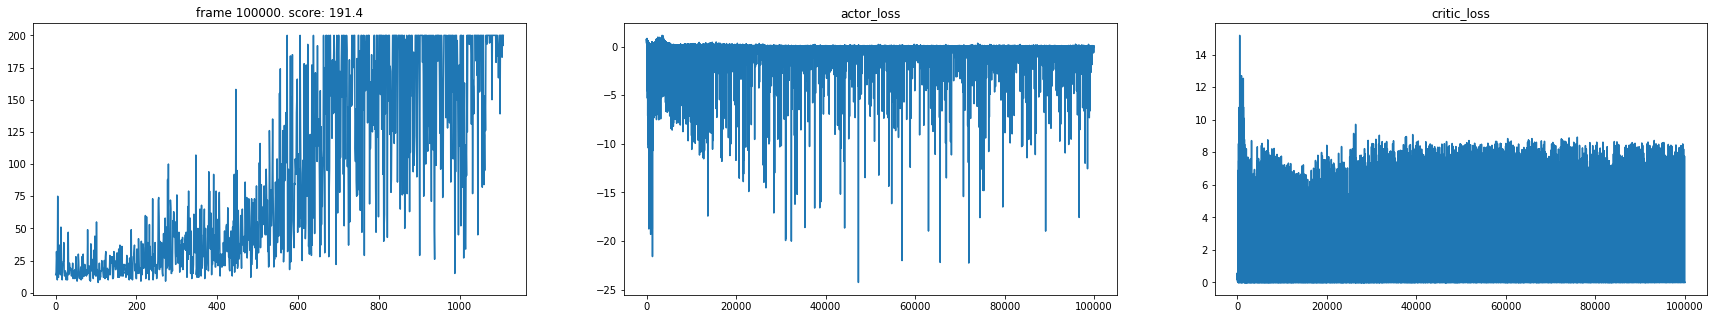

In [11]:
agent.train(num_frames)

In [17]:
frames = agent.test()

AssertionError: array(nan, dtype=float32) (<class 'numpy.ndarray'>) invalid

In [15]:
# Imports specifically so we can render outputs in Colab.
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display


def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))
    
        
# display 
display_frames_as_gif(frames)



NameError: name 'frames' is not defined